In [1]:
import os
import angr


filePath = '/home/nahid/reverse/binaries/gitfm'
proj = angr.Project(filePath)





WARNING  | 2023-02-18 16:40:33,190 | cle.loader     | The main binary is a position-independent executable. It is being loaded with a base address of 0x400000.


In [2]:
import monkeyhex # this will format numerical results in hexadecimal

print(proj.arch)

print(proj.entry)

print(proj.filename)

<Arch AMD64 (LE)>
4224128
/home/nahid/reverse/binaries/gitfm


In [3]:
print(proj.loader,'\n\n')

print("Shared Objects:")
for so in (proj.loader.shared_objects):
    print(so)
print()
    
    
    
print('min_addr',proj.loader.min_addr)

print('max_addr',proj.loader.max_addr)


print('main_object',proj.loader.main_object)  # we've loaded several binaries into this project. Here's the main one!


print('does this binary have an executable stack?: ',proj.loader.main_object.execstack)  # sample query: does this binary have an executable stack?

print('is this binary position-independent?',proj.loader.main_object.pic)  # sample query: is this binary position-independent?



<Loaded gitfm, maps [0x400000:0xc07fff]> 


Shared Objects:
gitfm
libtinfo.so.6
libc.so.6
ld-linux-x86-64.so.2
extern-address space
cle##tls

min_addr 4194304
max_addr 12615679
main_object <ELF Object gitfm, maps [0x400000:0x42bc87]>
does this binary have an executable stack?:  False
is this binary position-independent? True


PLT stub 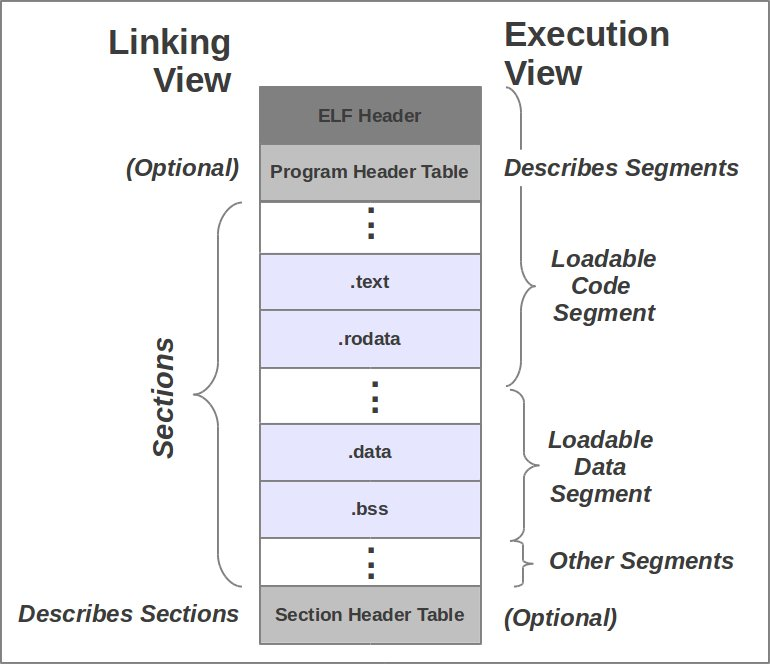

In [4]:
obj = proj.loader.main_object


print('# The entry point of the object',obj.entry)




print("Retrieve this ELF's segments and sections")

for segment in obj.segments:
    print('segment regions : ',segment)
print('\n\n')



for section in obj.sections:
    print("Section Regions: ",section)

            
# # You can get an individual segment or section by an address it contains:
print(" You can get an individual segment  by an address it contains:")
print('find_segment_containing(obj.entry)',obj.find_segment_containing(obj.entry))



print('\n')
print(" You can get an individual section by an address it contains:")

print("obj.find_section_containing(obj.entry)",obj.find_section_containing(obj.entry))



# # Get the address of the PLT stub for a symbol
# >>> addr = obj.plt['strcmp']
# >>> addr
# 0x400550
# >>> obj.reverse_plt[addr]
# 'strcmp'

# # Show the prelinked base of the object and the location it was actually mapped into memory by CLE
# >>> obj.linked_base
# 0x400000
# >>> obj.mapped_base
# 0x400000

# The entry point of the object 4224128
Retrieve this ELF's segments and sections
segment regions :  <ELFSegment flags=0x4, relro=0x0, vaddr=0x400000, memsize=0x37a8, filesize=0x37a8, offset=0x0>
segment regions :  <ELFSegment flags=0x5, relro=0x0, vaddr=0x404000, memsize=0x1b04d, filesize=0x1b04d, offset=0x4000>
segment regions :  <ELFSegment flags=0x4, relro=0x0, vaddr=0x420000, memsize=0x7340, filesize=0x7340, offset=0x20000>
segment regions :  <ELFSegment flags=0x4, relro=0x1, vaddr=0x428930, memsize=0x6d0, filesize=0x6d0, offset=0x27930>
segment regions :  <ELFSegment flags=0x6, relro=0x0, vaddr=0x429000, memsize=0x2c88, filesize=0x1830, offset=0x28000>



Section Regions:  <Unnamed | offset 0x0, vaddr 0x400000, size 0x0>
Section Regions:  <.interp | offset 0x318, vaddr 0x400318, size 0x1c>
Section Regions:  <.note.gnu.property | offset 0x338, vaddr 0x400338, size 0x30>
Section Regions:  <.note.gnu.build-id | offset 0x368, vaddr 0x400368, size 0x24>
Section Regions:  <.note.ABI-ta

In [5]:
import os
        
fh = open(filePath, 'rb')
bin_bytearray = bytearray(fh.read())


In [6]:
bin_bytearray[0:10]
print(len(bin_bytearray))

632456


In [7]:
code_section = obj.find_section_containing(obj.entry)

# offset = code_section.split("|")[1].split(',')[0].split()[1]

In [42]:
JUMP_OPCODES = ['JO','JNO','JS','JNS','JE','JZ','JNE','JNZ','JB','JNAE','JC','JNB','JAE','JNC','JBE','JNA','JA',
'JNBE','JL','JNGE','JGE','JNL','JLE','JNG','JG','JNLE','JP','JPE','JNP','JPO','JCXZ','JECXZ']


In [43]:
def int_list_to_hex_list(int_list):
    hex_list =[]
    for i in int_list:
        hex_list.append(hex(i))
    return hex_list


def hex_list_to_int_list(hex_list):
    int_list =[]
    for h in hex_list:
        int_list.append(int(i,0))
    return int_list

In [54]:
#took inspiration from capstone github sample code 

from capstone import *
from pprint import pprint


textSectionStart = code_section.offset #int(code_section.offset,0)
textSectionLen =  code_section.filesize#int(code_section.filesize,0)

textSectionEnd = textSectionStart+textSectionLen

print('Start: ',hex(code_section.offset) , "end: ", hex(textSectionEnd))

md = Cs(CS_ARCH_X86, CS_MODE_64)


visited_addresses = []
entry_addresses = []
address_and_instructions = []

entry_addresses.append(textSectionStart)
counter = 0
while len(entry_addresses)>0:
    
    
    print("_"*50,'\n')
    counter+=1
    if counter>100:
        break
#     print(int_list_to_hex_list(entry_addresses))
#     print(int_list_to_hex_list(visited_addresses))
    
    current_entry_address = entry_addresses.pop(0)
    
    if current_entry_address in visited_addresses:
        continue
    
    
    CODE = bin_bytearray[current_entry_address: textSectionEnd]
    for i in md.disasm(CODE, current_entry_address):
        print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))  
        

        address_and_instructions.append([i.address, i.mnemonic, i.op_str])
        
        visited_addresses.append(i.address)

        # IF there is a conditional jump
        if i.mnemonic.upper() in JUMP_OPCODES:
            try:
                if int(i.op_str,0)>=0:
                    if i.op_str not in visited_addresses:
                        print("\t\t\t> %s" %( i.op_str  ))  
                        
                        entry_addresses.append(int(i.op_str,0))
#                         break
    #                     print(int(i.op_str,0))
            except: 
                print('\t\t->->->                               indirect BRUNCH')
                break
        
                # IF there is a conditional jump
        if i.mnemonic.upper() in ['JMP']:
            print(i.op_str)
            try:
                if int(i.op_str,0)>=0:
                    
                    if int(i.op_str,0)>=textSectionStart and int(i.op_str,0)<=textSectionEnd:
                    
                        if i.op_str not in visited_addresses:
                            print("\t\t\t> %s" %( i.op_str  ))  

                            entry_addresses.append(int(i.op_str,0))
#                             break
                    
                    
            except:
                print('\t\t->->->                                  indirect JMP')
                break
                

Start:  0x4f20 end:  0x1f03e
__________________________________________________ 

0x4f20:	mov	byte ptr [rsp + 8], 0
0x4f25:	jmp	0x107fa
0x107fa
			> 0x107fa
0x4f2a:	call	0x4850
0x4f2f:	nop	
0x4f30:	endbr64	
0x4f34:	push	r15
0x4f36:	push	r14
0x4f38:	lea	r14, [rip + 0x1b669]
0x4f3f:	push	r13
0x4f41:	lea	r13, [rip + 0x1b2b4]
0x4f48:	push	r12
0x4f4a:	push	rbp
0x4f4b:	mov	ebp, edi
0x4f4d:	push	rbx
0x4f4e:	mov	rbx, rsi
0x4f51:	sub	rsp, 0x88
0x4f58:	mov	rax, qword ptr fs:[0x28]
0x4f61:	mov	qword ptr [rsp + 0x78], rax
0x4f66:	xor	eax, eax
0x4f68:	mov	dword ptr [rsp + 0x34], 0
0x4f70:	mov	qword ptr [rsp + 0x50], 0
0x4f79:	mov	qword ptr [rsp + 0x58], 0
0x4f82:	call	0x18c50
0x4f87:	lea	rsi, [rip + 0x1d457]
0x4f8e:	mov	edi, 6
0x4f93:	call	0x4d00
0x4f98:	mov	rax, qword ptr [rbx]
0x4f9b:	lea	rdi, [rip + 0x1b5be]
0x4fa2:	mov	qword ptr [rip + 0x2593f], rax
0x4fa9:	call	0x47e0
0x4fae:	lea	rdx, [rip + 0x1c729]
0x4fb5:	test	rax, rax
0x4fb8:	cmove	rax, rdx
0x4fbc:	mov	qword ptr [rip + 0x2592d], rax
0x4fc3